### 1. 研究問題:如何藉分群結果提高紅利點數的取用與使用率
基於前一個專案的分析結果，發現五校在紅利點數的取用與使用的比例都不高，故希望可以透過分群的方式，找出各群的特徵，並藉不同的特徵思考如何利用行銷策略來增加取用與使用率。

### 2 分群分析想法
- 會員特徵
    - 會員基本資料 : 性別、年齡、學校
    - POS : 平均每年來店消費頻率、平均每年消費金額、最常使用的支付方式、消費品類、是否使用禮券支付、是否使用紅利支付
    - 兌換券 : 平均每年兌換頻率、兌換類別
    - 紅利點數 : 平均每年兌換頻率


### 3. 分析結果

### Packeages Import

In [1]:
import pandas as pd
import numpy as np
import datetime

import matplotlib.pyplot as plt
# 設定全域字體大小
plt.rcParams['axes.titlesize'] = 16  # 圖形標題的字體大小
plt.rcParams['axes.labelsize'] = 14  # X、Y軸標籤的字體大小
plt.rcParams['xtick.labelsize'] = 12  # X軸刻度標籤的字體大小
plt.rcParams['ytick.labelsize'] = 12  # Y軸刻度標籤的字體大小
plt.rcParams['font.weight'] = 'bold'
plt.rcParams['font.family'] = ['Arial', 'Microsoft JhengHei']  # 定義中英文字體

# 分群相關套件
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from kmodes.kprototypes import KPrototypes


from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import plotly
import seaborn as sns

from tqdm import tqdm

### 4. 資料前處理
step1 : POS與會員資料合併  
step2 : 特徵選擇 : 消費頻率、消費金額、紅利使用次數、兌換券使用次數、產品品類偏好、是否使用禮券折抵、是否使用另折抵

In [2]:
# 保留客戶代號位數>6的資料,並整粒客戶代號新增至User_ID欄位，以待後續要與會員資料合併
pos = pd.read_csv('./raw_data/all_pos.csv')
pos = pos[pos['客戶代號'].astype(str).str.len() > 6]

# 提取數字部分並新增 UserID 欄位
pos['UserID'] = pos['客戶代號'].str.extract('(\d+)')

# 篩選出以 9 開頭的 UserID (因為後來篩出來的資料沒清乾淨所以多加這個條件)
pos = pos[pos['UserID'].str.startswith('9')]

# 顯示結果
pos.head()

,倉別名稱,客戶代號,單號,結帳日期,產品名稱,基本數量,類別名稱,實際銷貨價,實際銷售小計,已收現金,...,刷卡金額,一卡通實付金額,LinePay實付金額,獲得紅利,退回紅利,紅利取用,紅利取用退回,抵用金額,促銷組合獲得紅利點數,UserID
18,中山,D961360266,11001040090,110.01.04,Pentel 易拭型塑膠擦-小 #ZEL-05,2,設計、文具,10.0,20,84,...,0,0,0,84,0,0,0,0,0,961360266
19,中山,D961360266,11001040090,110.01.04,單面七彩索引片 17*26mm #WL-3066 華麗牌,1,設計、文具,12.0,12,84,...,0,0,0,84,0,0,0,0,0,961360266
20,中山,D961360266,11001040090,110.01.04,單面七彩索引片 17*42mm #WL-3065 華麗牌,1,設計、文具,12.0,12,84,...,0,0,0,84,0,0,0,0,0,961360266
21,中山,D961360266,11001040090,110.01.04,18K環保計算紙,2,設計、文具,20.0,40,84,...,0,0,0,84,0,0,0,0,0,961360266
22,中山,D963619834,11001040091,110.01.04,利百代LB5008CA工程計算機,1,設計、文具,199.0,199,199,...,0,0,0,199,0,0,0,0,0,963619834


In [3]:
member = pd.read_csv('./raw_data/(APP-會員含生日)mem20240403.csv')
member = member.drop(columns=['MBR_SCHOOL_ID','MBR_SCHOOL','CreatedDate','Birthday','UDF1','UDF4','Email','YahooID','UserName','ModifiedDate'])
member

,UserID,UserSex
0,919061387,0
1,916360484,1
2,983835662,1
3,979872208,0
4,979136556,0
...,...,...
20409,926796267,1
20410,903912882,1
20411,971236397,2
20412,988471089,1


In [4]:
# 將 UserID 欄位轉換為字串型別
member['UserID'] = member['UserID'].astype(str)
n_pos = pd.merge(pos,member, on = 'UserID', how='inner') # 只保留兩邊都擁有的UserID，撇除只有消費但沒有取用與使用紅利的帳戶
n_pos

,倉別名稱,客戶代號,單號,結帳日期,產品名稱,基本數量,類別名稱,實際銷貨價,實際銷售小計,已收現金,...,一卡通實付金額,LinePay實付金額,獲得紅利,退回紅利,紅利取用,紅利取用退回,抵用金額,促銷組合獲得紅利點數,UserID,UserSex
0,中山,D955825516,11001060268,110.01.06,SDI 精美自動鎖定型小美工刀 #0413C,2,設計、文具,24.0,48,154,...,0,0,154,0,6600,0,22,0,955825516,0
1,中山,D955825516,11001060268,110.01.06,SDI 黑色長尾夾 #0224B (32mm/12入裝),1,設計、文具,40.0,40,154,...,0,0,154,0,6600,0,22,0,955825516,0
2,中山,D955825516,11001060268,110.01.06,巨倫-日式叫人鈴,1,設計、文具,88.0,88,154,...,0,0,154,0,6600,0,22,0,955825516,0
3,中山,D955825516,11001060268,110.01.06,紅利折抵,1,促銷代碼,-22.0,-22,154,...,0,0,154,0,6600,0,22,0,955825516,0
4,中山,D955825516,11001080297,110.01.08,起豹男防風觸控手套-3色,1,穿搭配飾,289.0,289,289,...,0,0,289,0,0,0,0,0,955825516,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205515,義大,B965704422,11303201261,113.03.20,逸盛 USB3.0轉RJ45(A+C)/1000M 高速網路卡(銀) 01-RJ,1,3C,399.0,399,458,...,0,0,458,0,0,0,0,0,965704422,1
205516,義大,B965704422,11303201261,113.03.20,花香清潔袋(玫瑰/香茅)3入-大,1,生活百貨,59.0,59,458,...,0,0,458,0,0,0,0,0,965704422,1
205517,義大,C905813630,11303201271,113.03.20,黃阿瑪的後宮生活 貓咪超有事3-貓貓美食救援計畫,1,社會書,264.0,264,0,...,0,0,264,0,0,0,0,0,905813630,1
205518,義大,B908879198,11303201296,113.03.20,Power BI 快速入門,1,教科書,441.0,441,441,...,0,0,441,0,0,0,0,0,908879198,0


In [5]:
# 定義轉換函數
def to_datetime(taiwan_date):
    # 將民國年轉換成西元年
    year_offset = 1911
    parts = taiwan_date.split('.')
    year = int(parts[0]) + year_offset
    month = int(parts[1])
    day = int(parts[2])

    # 使用 datetime 將日期數據解析成日期對象
    date_obj = datetime.datetime(year, month, day)

    return date_obj

In [6]:
n_pos['新結帳日期'] = n_pos['結帳日期'].apply(to_datetime)
n_pos

,倉別名稱,客戶代號,單號,結帳日期,產品名稱,基本數量,類別名稱,實際銷貨價,實際銷售小計,已收現金,...,LinePay實付金額,獲得紅利,退回紅利,紅利取用,紅利取用退回,抵用金額,促銷組合獲得紅利點數,UserID,UserSex,新結帳日期
0,中山,D955825516,11001060268,110.01.06,SDI 精美自動鎖定型小美工刀 #0413C,2,設計、文具,24.0,48,154,...,0,154,0,6600,0,22,0,955825516,0,2021-01-06
1,中山,D955825516,11001060268,110.01.06,SDI 黑色長尾夾 #0224B (32mm/12入裝),1,設計、文具,40.0,40,154,...,0,154,0,6600,0,22,0,955825516,0,2021-01-06
2,中山,D955825516,11001060268,110.01.06,巨倫-日式叫人鈴,1,設計、文具,88.0,88,154,...,0,154,0,6600,0,22,0,955825516,0,2021-01-06
3,中山,D955825516,11001060268,110.01.06,紅利折抵,1,促銷代碼,-22.0,-22,154,...,0,154,0,6600,0,22,0,955825516,0,2021-01-06
4,中山,D955825516,11001080297,110.01.08,起豹男防風觸控手套-3色,1,穿搭配飾,289.0,289,289,...,0,289,0,0,0,0,0,955825516,0,2021-01-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205515,義大,B965704422,11303201261,113.03.20,逸盛 USB3.0轉RJ45(A+C)/1000M 高速網路卡(銀) 01-RJ,1,3C,399.0,399,458,...,0,458,0,0,0,0,0,965704422,1,2024-03-20
205516,義大,B965704422,11303201261,113.03.20,花香清潔袋(玫瑰/香茅)3入-大,1,生活百貨,59.0,59,458,...,0,458,0,0,0,0,0,965704422,1,2024-03-20
205517,義大,C905813630,11303201271,113.03.20,黃阿瑪的後宮生活 貓咪超有事3-貓貓美食救援計畫,1,社會書,264.0,264,0,...,0,264,0,0,0,0,0,905813630,1,2024-03-20
205518,義大,B908879198,11303201296,113.03.20,Power BI 快速入門,1,教科書,441.0,441,441,...,0,441,0,0,0,0,0,908879198,0,2024-03-20


In [7]:
#擷取新結帳日期的年月日
n_pos['Year'] = n_pos['新結帳日期'].dt.year
n_pos['Month'] = n_pos['新結帳日期'].dt.month
n_pos.head()

,倉別名稱,客戶代號,單號,結帳日期,產品名稱,基本數量,類別名稱,實際銷貨價,實際銷售小計,已收現金,...,退回紅利,紅利取用,紅利取用退回,抵用金額,促銷組合獲得紅利點數,UserID,UserSex,新結帳日期,Year,Month
0,中山,D955825516,11001060268,110.01.06,SDI 精美自動鎖定型小美工刀 #0413C,2,設計、文具,24.0,48,154,...,0,6600,0,22,0,955825516,0,2021-01-06,2021,1
1,中山,D955825516,11001060268,110.01.06,SDI 黑色長尾夾 #0224B (32mm/12入裝),1,設計、文具,40.0,40,154,...,0,6600,0,22,0,955825516,0,2021-01-06,2021,1
2,中山,D955825516,11001060268,110.01.06,巨倫-日式叫人鈴,1,設計、文具,88.0,88,154,...,0,6600,0,22,0,955825516,0,2021-01-06,2021,1
3,中山,D955825516,11001060268,110.01.06,紅利折抵,1,促銷代碼,-22.0,-22,154,...,0,6600,0,22,0,955825516,0,2021-01-06,2021,1
4,中山,D955825516,11001080297,110.01.08,起豹男防風觸控手套-3色,1,穿搭配飾,289.0,289,289,...,0,0,0,0,0,955825516,0,2021-01-08,2021,1


#### 4.1會員年消費平均次數

In [8]:
feq = n_pos[['UserID','UserSex','單號','Year','Month']]

#擷取第一單的紀錄:因為有些是同一筆單號但有多樣商品結單紀錄
feq = feq.groupby(['UserID','單號'])[['UserSex','Year']].first().reset_index()

# 計算年總消費平均
year_feq = feq.groupby(['UserID','Year']).size().reset_index(name='年總消費次數')

# 計算每個會員的年平均消費次數
avg_feq = year_feq.groupby('UserID')['年總消費次數'].mean().reset_index(name='年平均消費次數')
avg_feq

,UserID,年平均消費次數
0,900002568,3.666667
1,900008283,5.000000
2,900009691,3.000000
3,900011046,6.000000
4,900020718,1.500000
...,...,...
14848,989984332,2.000000
14849,989985917,6.000000
14850,989986908,1.666667
14851,989991647,3.000000


#### 4.2會員年平均消費金額(包含紅利取用與使用禮券的金額)

In [9]:
consume = n_pos.groupby(['UserID','Year'])['實際銷售小計'].sum().reset_index(name='消費總額')
consume

,UserID,Year,消費總額
0,900002568,2022,1154
1,900002568,2023,413
2,900002568,2024,205
3,900008283,2023,479
4,900008283,2024,255
...,...,...,...
27149,989986908,2023,75
27150,989986908,2024,20
27151,989991647,2023,182
27152,989995376,2022,482


In [10]:
avgconsume = consume.groupby('UserID')['消費總額'].mean().reset_index(name='年平均消費金額')
avgconsume

,UserID,年平均消費金額
0,900002568,590.666667
1,900008283,367.000000
2,900009691,1361.500000
3,900011046,779.000000
4,900020718,1120.500000
...,...,...
14848,989984332,1052.500000
14849,989985917,2297.000000
14850,989986908,68.666667
14851,989991647,182.000000


#### 4.3會員消費類別總計

In [11]:
# 先找出消費總共有多少類別
n_pos['類別名稱'].unique()

array(['設計、文具', '促銷代碼', '穿搭配飾', '社會書', '學校紀念品', '可諾進出口', '3C', '教科書',
       '生活百貨', '蘋果原廠產品', '藍海經銷', '不計算業績', '業外', '二手書', '其他', '食品', '美妝',
       '簡體字書', 'X[麗文禮券.]'], dtype=object)

In [12]:
# 找出每個會員購買資訊
cosumeType=n_pos[['UserID','單號','類別名稱']]
cosumeType

,UserID,單號,類別名稱
0,955825516,11001060268,設計、文具
1,955825516,11001060268,設計、文具
2,955825516,11001060268,設計、文具
3,955825516,11001060268,促銷代碼
4,955825516,11001080297,穿搭配飾
...,...,...,...
205515,965704422,11303201261,3C
205516,965704422,11303201261,生活百貨
205517,905813630,11303201271,社會書
205518,908879198,11303201296,教科書


In [13]:
# 使用One-hot encoding，標示類別是否存在於此資料
cosumeType = pd.get_dummies(cosumeType, columns=['類別名稱'])
cosumeType

,UserID,單號,類別名稱_3C,類別名稱_X[麗文禮券.],類別名稱_不計算業績,類別名稱_二手書,類別名稱_促銷代碼,類別名稱_其他,類別名稱_可諾進出口,類別名稱_學校紀念品,...,類別名稱_業外,類別名稱_生活百貨,類別名稱_社會書,類別名稱_穿搭配飾,類別名稱_簡體字書,類別名稱_美妝,類別名稱_藍海經銷,類別名稱_蘋果原廠產品,類別名稱_設計、文具,類別名稱_食品
0,955825516,11001060268,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,955825516,11001060268,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,955825516,11001060268,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
3,955825516,11001060268,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,955825516,11001080297,False,False,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205515,965704422,11303201261,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
205516,965704422,11303201261,False,False,False,False,False,False,False,False,...,False,True,False,False,False,False,False,False,False,False
205517,905813630,11303201271,False,False,False,False,False,False,False,False,...,False,False,True,False,False,False,False,False,False,False
205518,908879198,11303201296,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [14]:
# 將每個會員的所有購買過的類別記錄下來,並將單號移除
cosumeType=cosumeType.groupby(['UserID']).sum().reset_index()
cosumeType=cosumeType.drop(columns=['單號'])
cosumeType

,UserID,類別名稱_3C,類別名稱_X[麗文禮券.],類別名稱_不計算業績,類別名稱_二手書,類別名稱_促銷代碼,類別名稱_其他,類別名稱_可諾進出口,類別名稱_學校紀念品,類別名稱_教科書,類別名稱_業外,類別名稱_生活百貨,類別名稱_社會書,類別名稱_穿搭配飾,類別名稱_簡體字書,類別名稱_美妝,類別名稱_藍海經銷,類別名稱_蘋果原廠產品,類別名稱_設計、文具,類別名稱_食品
0,900002568,0,0,2,0,1,0,0,0,2,0,0,0,0,0,0,0,0,19,0
1,900008283,0,0,0,0,2,0,0,0,0,0,2,0,0,0,0,0,0,20,0
2,900009691,2,0,0,0,1,0,0,0,2,0,2,1,0,0,0,0,0,1,0
3,900011046,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,17,0
4,900020718,0,0,2,0,2,0,0,0,2,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14848,989984332,1,0,0,0,3,0,0,0,3,0,0,0,0,0,0,0,0,3,0
14849,989985917,1,0,3,0,1,0,0,0,1,0,0,0,0,0,0,0,0,18,0
14850,989986908,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,0,2,0
14851,989991647,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0


#### 4.4是否曾經使用過紅利、禮券折抵

In [15]:
# 會員是否曾使用discount
n_pos['紅利取用標記'] = n_pos.groupby('UserID')['紅利取用'].transform(lambda x: 1 if x.sum() > 0 else 0)
n_pos['禮券折抵標記'] = n_pos.groupby('UserID')['禮券金額'].transform(lambda x: 1 if x.sum() > 0 else 0)
n_pos

,倉別名稱,客戶代號,單號,結帳日期,產品名稱,基本數量,類別名稱,實際銷貨價,實際銷售小計,已收現金,...,紅利取用退回,抵用金額,促銷組合獲得紅利點數,UserID,UserSex,新結帳日期,Year,Month,紅利取用標記,禮券折抵標記
0,中山,D955825516,11001060268,110.01.06,SDI 精美自動鎖定型小美工刀 #0413C,2,設計、文具,24.0,48,154,...,0,22,0,955825516,0,2021-01-06,2021,1,1,0
1,中山,D955825516,11001060268,110.01.06,SDI 黑色長尾夾 #0224B (32mm/12入裝),1,設計、文具,40.0,40,154,...,0,22,0,955825516,0,2021-01-06,2021,1,1,0
2,中山,D955825516,11001060268,110.01.06,巨倫-日式叫人鈴,1,設計、文具,88.0,88,154,...,0,22,0,955825516,0,2021-01-06,2021,1,1,0
3,中山,D955825516,11001060268,110.01.06,紅利折抵,1,促銷代碼,-22.0,-22,154,...,0,22,0,955825516,0,2021-01-06,2021,1,1,0
4,中山,D955825516,11001080297,110.01.08,起豹男防風觸控手套-3色,1,穿搭配飾,289.0,289,289,...,0,0,0,955825516,0,2021-01-08,2021,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
205515,義大,B965704422,11303201261,113.03.20,逸盛 USB3.0轉RJ45(A+C)/1000M 高速網路卡(銀) 01-RJ,1,3C,399.0,399,458,...,0,0,0,965704422,1,2024-03-20,2024,3,1,0
205516,義大,B965704422,11303201261,113.03.20,花香清潔袋(玫瑰/香茅)3入-大,1,生活百貨,59.0,59,458,...,0,0,0,965704422,1,2024-03-20,2024,3,1,0
205517,義大,C905813630,11303201271,113.03.20,黃阿瑪的後宮生活 貓咪超有事3-貓貓美食救援計畫,1,社會書,264.0,264,0,...,0,0,0,905813630,1,2024-03-20,2024,3,0,0
205518,義大,B908879198,11303201296,113.03.20,Power BI 快速入門,1,教科書,441.0,441,441,...,0,0,0,908879198,0,2024-03-20,2024,3,1,0


In [16]:
# 該會員是否曾使用
discountuseORnot = n_pos.groupby('UserID')[["紅利取用標記",'禮券折抵標記']].max()
discountuseORnot

,紅利取用標記,禮券折抵標記
UserID,,
900002568,1,0
900008283,0,0
900009691,0,0
900011046,0,0
900020718,0,0
...,...,...
989984332,0,0
989985917,1,0
989986908,0,0


In [17]:
# 會員使用折抵的頻率
discoutFre = n_pos[["UserID","單號",'紅利取用',"禮券金額","Year","Month"]]
# 去除重複紀錄
discoutFre=discoutFre.groupby(['UserID','單號'])[['紅利取用','禮券金額','Month',"Year"]].count().reset_index()
discoutFre

,UserID,單號,紅利取用,禮券金額,Month,Year
0,900002568,11110201172,2,2,2,2
1,900002568,11202201724,2,2,2,2
2,900002568,11203080497,1,1,1,1
3,900002568,11205020185,4,4,4,4
4,900002568,11209184727,2,2,2,2
...,...,...,...,...,...,...
89385,989995376,11210030642,2,2,2,2
89386,989995376,11210031398,1,1,1,1
89387,989995376,11210121742,1,1,1,1
89388,989995376,11210191371,1,1,1,1


In [18]:
# 各會員每年折抵使用頻率
discoutFre = discoutFre.groupby(["UserID","Year"])[["紅利取用", "禮券金額"]].count().reset_index()
discoutFre

,UserID,Year,紅利取用,禮券金額
0,900002568,1,4,4
1,900002568,2,3,3
2,900002568,3,2,2
3,900002568,4,2,2
4,900008283,1,4,4
...,...,...,...,...
38893,989991647,1,2,2
38894,989991647,2,1,1
38895,989995376,1,10,10
38896,989995376,2,4,4


In [19]:
discoutFre=discoutFre.groupby(["UserID"])[["紅利取用", "禮券金額"]].mean().reset_index()
discoutFre

,UserID,紅利取用,禮券金額
0,900002568,2.750000,2.750000
1,900008283,2.500000,2.500000
2,900009691,2.000000,2.000000
3,900011046,4.000000,4.000000
4,900020718,1.500000,1.500000
...,...,...,...
14848,989984332,1.333333,1.333333
14849,989985917,1.500000,1.500000
14850,989986908,2.500000,2.500000
14851,989991647,1.500000,1.500000


#### 4.5支付方式類別比例

In [20]:
payType = n_pos[["UserID","單號",'已收現金',"刷卡金額","一卡通實付金額","LinePay實付金額","Year","Month"]]
payType

,UserID,單號,已收現金,刷卡金額,一卡通實付金額,LinePay實付金額,Year,Month
0,955825516,11001060268,154,0,0,0,2021,1
1,955825516,11001060268,154,0,0,0,2021,1
2,955825516,11001060268,154,0,0,0,2021,1
3,955825516,11001060268,154,0,0,0,2021,1
4,955825516,11001080297,289,0,0,0,2021,1
...,...,...,...,...,...,...,...,...
205515,965704422,11303201261,458,0,0,0,2024,3
205516,965704422,11303201261,458,0,0,0,2024,3
205517,905813630,11303201271,0,264,0,0,2024,3
205518,908879198,11303201296,441,0,0,0,2024,3


In [21]:
payType = payType.groupby(["UserID","單號"])[["已收現金","刷卡金額","一卡通實付金額","LinePay實付金額"]].max().reset_index()
payType

,UserID,單號,已收現金,刷卡金額,一卡通實付金額,LinePay實付金額
0,900002568,11110201172,0,1154,0,0
1,900002568,11202201724,8,0,0,0
2,900002568,11203080497,36,0,0,0
3,900002568,11205020185,0,0,0,132
4,900002568,11209184727,85,0,0,0
...,...,...,...,...,...,...
89385,989995376,11210030642,54,0,0,0
89386,989995376,11210031398,93,0,0,0
89387,989995376,11210121742,470,0,0,0
89388,989995376,11210191371,64,0,0,0


In [22]:
payType['已收現金'] = (payType['已收現金'] > 0).astype(int)
payType['刷卡金額'] = (payType['刷卡金額'] > 0).astype(int)
payType['一卡通實付金額'] = (payType['一卡通實付金額'] > 0).astype(int)
payType['LinePay實付金額'] = (payType['LinePay實付金額'] > 0).astype(int)
payType

,UserID,單號,已收現金,刷卡金額,一卡通實付金額,LinePay實付金額
0,900002568,11110201172,0,1,0,0
1,900002568,11202201724,1,0,0,0
2,900002568,11203080497,1,0,0,0
3,900002568,11205020185,0,0,0,1
4,900002568,11209184727,1,0,0,0
...,...,...,...,...,...,...
89385,989995376,11210030642,1,0,0,0
89386,989995376,11210031398,1,0,0,0
89387,989995376,11210121742,1,0,0,0
89388,989995376,11210191371,1,0,0,0


In [23]:
# 會員支付方式比例
payType = payType.groupby(["UserID"])[["已收現金", "刷卡金額","一卡通實付金額","LinePay實付金額"]].mean().reset_index()
payType

,UserID,已收現金,刷卡金額,一卡通實付金額,LinePay實付金額
0,900002568,0.636364,0.181818,0.0,0.181818
1,900008283,1.000000,0.000000,0.0,0.000000
2,900009691,0.666667,0.333333,0.0,0.000000
3,900011046,0.750000,0.250000,0.0,0.000000
4,900020718,1.000000,0.000000,0.0,0.000000
...,...,...,...,...,...
14848,989984332,1.000000,0.000000,0.0,0.000000
14849,989985917,0.500000,0.000000,0.0,0.166667
14850,989986908,1.000000,0.000000,0.0,0.000000
14851,989991647,1.000000,0.000000,0.0,0.000000


#### 4.6合併上述特徵

In [24]:
member = n_pos[["UserID",'倉別名稱',"UserSex"]]
member.drop_duplicates(subset=['UserID'],inplace=True)
member = pd.get_dummies(member, columns=['倉別名稱'])
member

C:\Users\Shelly\AppData\Local\Temp\ipykernel_3748\2051662817.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  member.drop_duplicates(subset=['UserID'],inplace=True)


,UserID,UserSex,倉別名稱_中山,倉別名稱_中正,倉別名稱_南臺,倉別名稱_淡江,倉別名稱_義大
0,955825516,0,True,False,False,False,False
10,903632160,1,True,False,False,False,False
21,983835662,1,True,False,False,False,False
23,979872208,0,True,False,False,False,False
34,979878010,2,True,False,False,False,False
...,...,...,...,...,...,...,...
205396,983020530,0,False,False,False,False,True
205399,958016116,1,False,False,False,False,True
205465,916420981,1,False,False,False,False,True
205476,982020831,0,False,False,False,False,True


In [25]:
# 合并所有表到 "member" 表中
member = member.merge(avgconsume, on='UserID', how='left')
member = member.merge(avg_feq, on='UserID', how='left')
member = member.merge(cosumeType, on='UserID', how='left')
member = member.merge(payType, on='UserID', how='left')
member = member.merge(discoutFre, on='UserID', how='left')
member

,UserID,UserSex,倉別名稱_中山,倉別名稱_中正,倉別名稱_南臺,倉別名稱_淡江,倉別名稱_義大,年平均消費金額,年平均消費次數,類別名稱_3C,...,類別名稱_藍海經銷,類別名稱_蘋果原廠產品,類別名稱_設計、文具,類別名稱_食品,已收現金,刷卡金額,一卡通實付金額,LinePay實付金額,紅利取用,禮券金額
0,955825516,0,True,False,False,False,False,3002.000000,16.500000,1,...,0,5,72,0,1.000,0.0,0.00,0.00,4.714286,4.714286
1,903632160,1,True,False,False,False,False,373.666667,2.666667,1,...,0,0,6,0,0.625,0.0,0.00,0.25,2.666667,2.666667
2,983835662,1,True,False,False,False,False,944.500000,3.750000,0,...,0,1,15,1,1.000,0.0,0.00,0.00,3.000000,3.000000
3,979872208,0,True,False,False,False,False,1924.000000,3.333333,1,...,0,0,13,0,1.000,0.0,0.00,0.00,2.000000,2.000000
4,979878010,2,True,False,False,False,False,1722.750000,5.000000,3,...,0,1,29,0,0.650,0.0,0.05,0.30,4.000000,4.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14848,983020530,0,False,False,False,False,True,64.000000,1.000000,0,...,0,0,1,0,1.000,0.0,0.00,0.00,1.000000,1.000000
14849,958016116,1,False,False,False,False,True,349.000000,1.000000,1,...,0,0,0,0,0.000,1.0,0.00,0.00,1.000000,1.000000
14850,916420981,1,False,False,False,False,True,1288.000000,1.000000,0,...,0,0,0,0,1.000,1.0,0.00,0.00,1.000000,1.000000
14851,982020831,0,False,False,False,False,True,855.000000,1.000000,0,...,0,0,0,0,1.000,1.0,0.00,0.00,1.000000,1.000000


In [26]:
# 去掉UserSex為2的資料
member = member[member['UserSex'] != 2]
member

,UserID,UserSex,倉別名稱_中山,倉別名稱_中正,倉別名稱_南臺,倉別名稱_淡江,倉別名稱_義大,年平均消費金額,年平均消費次數,類別名稱_3C,...,類別名稱_藍海經銷,類別名稱_蘋果原廠產品,類別名稱_設計、文具,類別名稱_食品,已收現金,刷卡金額,一卡通實付金額,LinePay實付金額,紅利取用,禮券金額
0,955825516,0,True,False,False,False,False,3002.000000,16.500000,1,...,0,5,72,0,1.000,0.0,0.0,0.00,4.714286,4.714286
1,903632160,1,True,False,False,False,False,373.666667,2.666667,1,...,0,0,6,0,0.625,0.0,0.0,0.25,2.666667,2.666667
2,983835662,1,True,False,False,False,False,944.500000,3.750000,0,...,0,1,15,1,1.000,0.0,0.0,0.00,3.000000,3.000000
3,979872208,0,True,False,False,False,False,1924.000000,3.333333,1,...,0,0,13,0,1.000,0.0,0.0,0.00,2.000000,2.000000
5,919061387,0,True,False,False,False,False,515.000000,2.500000,1,...,0,0,3,0,1.000,0.0,0.0,0.00,2.500000,2.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14848,983020530,0,False,False,False,False,True,64.000000,1.000000,0,...,0,0,1,0,1.000,0.0,0.0,0.00,1.000000,1.000000
14849,958016116,1,False,False,False,False,True,349.000000,1.000000,1,...,0,0,0,0,0.000,1.0,0.0,0.00,1.000000,1.000000
14850,916420981,1,False,False,False,False,True,1288.000000,1.000000,0,...,0,0,0,0,1.000,1.0,0.0,0.00,1.000000,1.000000
14851,982020831,0,False,False,False,False,True,855.000000,1.000000,0,...,0,0,0,0,1.000,1.0,0.0,0.00,1.000000,1.000000


In [27]:
# 重新整理欄位名稱
member = member.rename(columns={
    '已收現金': '現金支付比例',
    '刷卡金額': '刷卡支付比例',
    '一卡通實付金額': '一卡通支付比例',
    'LinePay實付金額': 'LinePay支付比例',
    '紅利取用': '紅利年平均折抵次數',
    '禮券金額': '禮卷年平均折抵次數'
})
member

,UserID,UserSex,倉別名稱_中山,倉別名稱_中正,倉別名稱_南臺,倉別名稱_淡江,倉別名稱_義大,年平均消費金額,年平均消費次數,類別名稱_3C,...,類別名稱_藍海經銷,類別名稱_蘋果原廠產品,類別名稱_設計、文具,類別名稱_食品,現金支付比例,刷卡支付比例,一卡通支付比例,LinePay支付比例,紅利年平均折抵次數,禮卷年平均折抵次數
0,955825516,0,True,False,False,False,False,3002.000000,16.500000,1,...,0,5,72,0,1.000,0.0,0.0,0.00,4.714286,4.714286
1,903632160,1,True,False,False,False,False,373.666667,2.666667,1,...,0,0,6,0,0.625,0.0,0.0,0.25,2.666667,2.666667
2,983835662,1,True,False,False,False,False,944.500000,3.750000,0,...,0,1,15,1,1.000,0.0,0.0,0.00,3.000000,3.000000
3,979872208,0,True,False,False,False,False,1924.000000,3.333333,1,...,0,0,13,0,1.000,0.0,0.0,0.00,2.000000,2.000000
5,919061387,0,True,False,False,False,False,515.000000,2.500000,1,...,0,0,3,0,1.000,0.0,0.0,0.00,2.500000,2.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14848,983020530,0,False,False,False,False,True,64.000000,1.000000,0,...,0,0,1,0,1.000,0.0,0.0,0.00,1.000000,1.000000
14849,958016116,1,False,False,False,False,True,349.000000,1.000000,1,...,0,0,0,0,0.000,1.0,0.0,0.00,1.000000,1.000000
14850,916420981,1,False,False,False,False,True,1288.000000,1.000000,0,...,0,0,0,0,1.000,1.0,0.0,0.00,1.000000,1.000000
14851,982020831,0,False,False,False,False,True,855.000000,1.000000,0,...,0,0,0,0,1.000,1.0,0.0,0.00,1.000000,1.000000


#### 4.7年平均兌換兌換券次數

In [28]:
coupon = pd.read_csv('./raw_data/(APP-點數兌換)_coupon.csv')
coupon

,MBR_SCHOOL_ID,MBR_SCHOOL,UserID,UserName,UserSex,UDF1,UDF4,Email,YahooID,PointDate,CouponCode,Name,Amount,IsUsed,AssignDate,ExpireDate
0,09,國立中山大學,900761212,侯佩妘,1,2021,NaN,peggy10341@gmail.com,D900761212,2022-06-18 00:11:47.480,D172,【門市取貨】UNI 限定版小小兵摩樂筆（款式隨機）,10,1,2022-06-18 12:30:18.557,2022-09-06 17:33:09.253
1,09,國立中山大學,900761212,侯佩妘,1,2021,NaN,peggy10341@gmail.com,D900761212,2021-12-30 08:13:27.313,C036,【門市取貨】熊熊捲線器,8,1,2021-12-30 12:16:07.930,2022-01-14 12:09:24.993
2,09,國立中山大學,902166568,張少銘,0,2021,三年級甲班,eric21204311@gmail.com,D902166568,2022-09-08 10:38:43.263,Z220,【門市獨家活動】（09/06上架）開學折抵金 5元,500,1,2022-09-08 10:40:06.090,2022-09-13 10:46:22.500
3,09,國立中山大學,902329869,陳威保,0,2021,NaN,1l3920901@gmaip.com,D902329869,2021-10-26 12:03:43.003,Z041,【會員大好康】100點免費抽(舒適生活空氣清淨機抽獎卷5),200,1,2021-10-26 12:26:32.220,2021-10-26 12:26:52.127
4,09,國立中山大學,903483681,陸嘉康,0,2021,NaN,aron920102@gmail.com,D903483681,2022-02-23 14:42:58.923,Z121,【門市專用】50元消費折抵金（2022/02）,100,1,2022-02-23 15:52:01.177,2022-02-23 15:52:12.777
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6402,G6,義守大學(醫學院分部),988634590,陳沛妤,1,2023,NaN,sky245680@gmail.com,C988634590,2023-09-21 17:29:16.567,Z9-23,【門市取貨】麥香紅茶300ml(限量),6240,1,2023-09-21 17:30:15.067,2023-09-21 17:31:02.223
6403,G6,義守大學(醫學院分部),988763076,蔡秉儒,1,2023,NaN,isu11256042A@cloud.isu.edu.tw,B988763076,2023-09-07 11:39:33.283,P2309-7,【義守大學專屬】50點免費抽：義大遊樂世界門票／兩張一組(0907),100,1,2023-09-07 11:41:32.440,2023-09-07 11:41:39.220
6404,G6,義守大學(醫學院分部),988763076,蔡秉儒,1,2023,NaN,isu11256042A@cloud.isu.edu.tw,B988763076,2023-09-07 11:39:33.283,Z9-23,【門市取貨】麥香紅茶300ml(限量),6240,1,2023-09-07 11:41:02.440,2023-09-07 11:41:07.827
6405,G6,義守大學(醫學院分部),988964113,賴巧蓉,1,2023,一,Cindy0988964113,C988964113,2023-09-21 12:43:57.207,Z9-23,【門市取貨】麥香紅茶300ml(限量),6240,1,2023-09-21 12:44:41.880,2023-09-21 12:44:48.690


In [29]:
# 兌換資料整理
coupon = coupon.drop(columns=['UDF1','UDF4','Email','YahooID','MBR_SCHOOL_ID'])
coupon['Name'] = coupon['Name'].str.extract(r'【(.*?)】')
coupon

,MBR_SCHOOL,UserID,UserName,UserSex,PointDate,CouponCode,Name,Amount,IsUsed,AssignDate,ExpireDate
0,國立中山大學,900761212,侯佩妘,1,2022-06-18 00:11:47.480,D172,門市取貨,10,1,2022-06-18 12:30:18.557,2022-09-06 17:33:09.253
1,國立中山大學,900761212,侯佩妘,1,2021-12-30 08:13:27.313,C036,門市取貨,8,1,2021-12-30 12:16:07.930,2022-01-14 12:09:24.993
2,國立中山大學,902166568,張少銘,0,2022-09-08 10:38:43.263,Z220,門市獨家活動,500,1,2022-09-08 10:40:06.090,2022-09-13 10:46:22.500
3,國立中山大學,902329869,陳威保,0,2021-10-26 12:03:43.003,Z041,會員大好康,200,1,2021-10-26 12:26:32.220,2021-10-26 12:26:52.127
4,國立中山大學,903483681,陸嘉康,0,2022-02-23 14:42:58.923,Z121,門市專用,100,1,2022-02-23 15:52:01.177,2022-02-23 15:52:12.777
...,...,...,...,...,...,...,...,...,...,...,...
6402,義守大學(醫學院分部),988634590,陳沛妤,1,2023-09-21 17:29:16.567,Z9-23,門市取貨,6240,1,2023-09-21 17:30:15.067,2023-09-21 17:31:02.223
6403,義守大學(醫學院分部),988763076,蔡秉儒,1,2023-09-07 11:39:33.283,P2309-7,義守大學專屬,100,1,2023-09-07 11:41:32.440,2023-09-07 11:41:39.220
6404,義守大學(醫學院分部),988763076,蔡秉儒,1,2023-09-07 11:39:33.283,Z9-23,門市取貨,6240,1,2023-09-07 11:41:02.440,2023-09-07 11:41:07.827
6405,義守大學(醫學院分部),988964113,賴巧蓉,1,2023-09-21 12:43:57.207,Z9-23,門市取貨,6240,1,2023-09-21 12:44:41.880,2023-09-21 12:44:48.690


In [30]:
# 兌換時間整理
coupon['AssignDate'] = pd.to_datetime(coupon['AssignDate'])

# 新增年、月的欄位
coupon['Year'] = coupon['AssignDate'].dt.year
coupon['Month'] = coupon['AssignDate'].dt.month
coupon = coupon.drop(columns=['PointDate', 'AssignDate', 'ExpireDate'])
coupon = coupon.drop(columns=['CouponCode', 'Amount', 'IsUsed'])
coupon

,MBR_SCHOOL,UserID,UserName,UserSex,Name,Year,Month
0,國立中山大學,900761212,侯佩妘,1,門市取貨,2022,6
1,國立中山大學,900761212,侯佩妘,1,門市取貨,2021,12
2,國立中山大學,902166568,張少銘,0,門市獨家活動,2022,9
3,國立中山大學,902329869,陳威保,0,會員大好康,2021,10
4,國立中山大學,903483681,陸嘉康,0,門市專用,2022,2
...,...,...,...,...,...,...,...
6402,義守大學(醫學院分部),988634590,陳沛妤,1,門市取貨,2023,9
6403,義守大學(醫學院分部),988763076,蔡秉儒,1,義守大學專屬,2023,9
6404,義守大學(醫學院分部),988763076,蔡秉儒,1,門市取貨,2023,9
6405,義守大學(醫學院分部),988964113,賴巧蓉,1,門市取貨,2023,9


In [31]:
# 各會員年兌換頻率
member_coupon_freq=coupon.groupby(['UserID','Year']).size().reset_index(name='年總兌換次數')
avgcoupon_freq = member_coupon_freq.groupby('UserID')['年總兌換次數'].mean().reset_index(name='年平均兌換頻率')
avgcoupon_freq

,UserID,年平均兌換頻率
0,900002568,1.0
1,900008283,1.0
2,900029578,1.0
3,900029961,1.0
4,900030001,1.0
...,...,...
3508,989919690,1.0
3509,989971965,11.0
3510,989972056,1.0
3511,989981078,1.0


#### 4.8所有購買行為合併

In [32]:
# 轉換資料型態、合併
avgcoupon_freq['UserID'] = avgcoupon_freq['UserID'].astype(str)

allfeature= pd.merge(member,avgcoupon_freq, how = 'left', on = 'UserID')
allfeature

,UserID,UserSex,倉別名稱_中山,倉別名稱_中正,倉別名稱_南臺,倉別名稱_淡江,倉別名稱_義大,年平均消費金額,年平均消費次數,類別名稱_3C,...,類別名稱_蘋果原廠產品,類別名稱_設計、文具,類別名稱_食品,現金支付比例,刷卡支付比例,一卡通支付比例,LinePay支付比例,紅利年平均折抵次數,禮卷年平均折抵次數,年平均兌換頻率
0,955825516,0,True,False,False,False,False,3002.000000,16.500000,1,...,5,72,0,1.000,0.0,0.0,0.00,4.714286,4.714286,NaN
1,903632160,1,True,False,False,False,False,373.666667,2.666667,1,...,0,6,0,0.625,0.0,0.0,0.25,2.666667,2.666667,NaN
2,983835662,1,True,False,False,False,False,944.500000,3.750000,0,...,1,15,1,1.000,0.0,0.0,0.00,3.000000,3.000000,NaN
3,979872208,0,True,False,False,False,False,1924.000000,3.333333,1,...,0,13,0,1.000,0.0,0.0,0.00,2.000000,2.000000,NaN
4,919061387,0,True,False,False,False,False,515.000000,2.500000,1,...,0,3,0,1.000,0.0,0.0,0.00,2.500000,2.500000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14086,983020530,0,False,False,False,False,True,64.000000,1.000000,0,...,0,1,0,1.000,0.0,0.0,0.00,1.000000,1.000000,NaN
14087,958016116,1,False,False,False,False,True,349.000000,1.000000,1,...,0,0,0,0.000,1.0,0.0,0.00,1.000000,1.000000,NaN
14088,916420981,1,False,False,False,False,True,1288.000000,1.000000,0,...,0,0,0,1.000,1.0,0.0,0.00,1.000000,1.000000,NaN
14089,982020831,0,False,False,False,False,True,855.000000,1.000000,0,...,0,0,0,1.000,1.0,0.0,0.00,1.000000,1.000000,NaN


In [33]:
# 將年平均兌換頻率為空值的資料填充0
allfeature['年平均兌換頻率'].fillna(0, inplace=True)
allfeature.head(100)

C:\Users\Shelly\AppData\Local\Temp\ipykernel_3748\3516689042.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  allfeature['年平均兌換頻率'].fillna(0, inplace=True)


,UserID,UserSex,倉別名稱_中山,倉別名稱_中正,倉別名稱_南臺,倉別名稱_淡江,倉別名稱_義大,年平均消費金額,年平均消費次數,類別名稱_3C,...,類別名稱_蘋果原廠產品,類別名稱_設計、文具,類別名稱_食品,現金支付比例,刷卡支付比例,一卡通支付比例,LinePay支付比例,紅利年平均折抵次數,禮卷年平均折抵次數,年平均兌換頻率
0,955825516,0,True,False,False,False,False,3002.000000,16.500000,1,...,5,72,0,1.000000,0.0,0.000000,0.000000,4.714286,4.714286,0.0
1,903632160,1,True,False,False,False,False,373.666667,2.666667,1,...,0,6,0,0.625000,0.0,0.000000,0.250000,2.666667,2.666667,0.0
2,983835662,1,True,False,False,False,False,944.500000,3.750000,0,...,1,15,1,1.000000,0.0,0.000000,0.000000,3.000000,3.000000,0.0
3,979872208,0,True,False,False,False,False,1924.000000,3.333333,1,...,0,13,0,1.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.0
4,919061387,0,True,False,False,False,False,515.000000,2.500000,1,...,0,3,0,1.000000,0.0,0.000000,0.000000,2.500000,2.500000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,939728678,0,True,False,False,False,False,4318.000000,3.666667,1,...,0,3,0,1.000000,0.0,0.000000,0.000000,3.666667,3.666667,0.0
96,903025468,0,True,False,False,False,False,1031.500000,4.000000,0,...,0,10,0,1.000000,0.0,0.000000,0.000000,2.000000,2.000000,0.0
97,905725844,0,True,False,False,False,False,2811.000000,5.500000,0,...,0,55,0,0.863636,0.0,0.000000,0.000000,2.750000,2.750000,1.0
98,909596211,1,True,False,False,False,False,1373.500000,3.500000,4,...,0,4,0,0.428571,0.0,0.000000,0.571429,3.500000,3.500000,0.0


- 因為學校可能會是主導分群的結果之一，所以先去除，也比較好擬定適合五校的行銷方案

In [34]:
allfeature = allfeature.drop(columns=['倉別名稱_中山','倉別名稱_中正','倉別名稱_南臺','倉別名稱_淡江','倉別名稱_義大'])

In [35]:
allfeature.columns = (
    allfeature.columns
      .str.replace(r'^[#\s]*[XＸ]?\[?', '', regex=True)   # 移掉開頭的 #、空白、X[ 或 Ｘ[
      .str.replace(r'\]', '', regex=True)                 # 移掉右括號 ]
      .str.replace(r'\.', '', regex=True)                 # 移掉句號 .
      .str.replace('類別名稱_', '', regex=False)          # 移掉前綴
      .str.strip()                                        # 去掉空白
)
allfeature


,UserID,UserSex,年平均消費金額,年平均消費次數,3C,X[麗文禮券,不計算業績,二手書,促銷代碼,其他,...,蘋果原廠產品,設計、文具,食品,現金支付比例,刷卡支付比例,一卡通支付比例,LinePay支付比例,紅利年平均折抵次數,禮卷年平均折抵次數,年平均兌換頻率
0,955825516,0,3002.000000,16.500000,1,0,0,0,4,0,...,5,72,0,1.000,0.0,0.0,0.00,4.714286,4.714286,0.0
1,903632160,1,373.666667,2.666667,1,0,1,0,4,0,...,0,6,0,0.625,0.0,0.0,0.25,2.666667,2.666667,0.0
2,983835662,1,944.500000,3.750000,0,0,2,0,3,0,...,1,15,1,1.000,0.0,0.0,0.00,3.000000,3.000000,0.0
3,979872208,0,1924.000000,3.333333,1,0,0,0,3,0,...,0,13,0,1.000,0.0,0.0,0.00,2.000000,2.000000,0.0
4,919061387,0,515.000000,2.500000,1,0,0,1,1,0,...,0,3,0,1.000,0.0,0.0,0.00,2.500000,2.500000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14086,983020530,0,64.000000,1.000000,0,0,0,0,0,0,...,0,1,0,1.000,0.0,0.0,0.00,1.000000,1.000000,0.0
14087,958016116,1,349.000000,1.000000,1,0,0,0,0,0,...,0,0,0,0.000,1.0,0.0,0.00,1.000000,1.000000,0.0
14088,916420981,1,1288.000000,1.000000,0,0,0,0,0,0,...,0,0,0,1.000,1.0,0.0,0.00,1.000000,1.000000,0.0
14089,982020831,0,855.000000,1.000000,0,0,0,0,0,0,...,0,0,0,1.000,1.0,0.0,0.00,1.000000,1.000000,0.0


- 透過標準差找出哪些欄位需要被標準化

In [36]:
allfeature.describe()

,UserSex,年平均消費金額,年平均消費次數,3C,X[麗文禮券,不計算業績,二手書,促銷代碼,其他,可諾進出口,...,蘋果原廠產品,設計、文具,食品,現金支付比例,刷卡支付比例,一卡通支付比例,LinePay支付比例,紅利年平均折抵次數,禮卷年平均折抵次數,年平均兌換頻率
count,14091.000000,14091.000000,14091.000000,14091.000000,14091.000000,14091.000000,14091.000000,14091.000000,14091.000000,14091.000000,...,14091.000000,14091.000000,14091.000000,14091.000000,14091.000000,14091.000000,14091.000000,14091.000000,14091.000000,14091.000000
mean,0.525513,1382.109869,2.948324,0.462991,0.000781,0.911007,0.004613,1.750337,0.122348,0.031580,...,0.019232,6.745724,0.028671,0.771401,0.053290,0.087862,0.089457,2.030460,2.030460,0.344795
std,0.499366,3743.935344,2.285444,1.272225,0.038598,2.296453,0.093318,3.090585,1.897798,0.203404,...,0.205286,10.471123,0.332999,0.334740,0.175211,0.220222,0.230371,1.311572,1.311572,0.884311
min,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,0.000000,369.125000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,1.000000,0.000000,0.625000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
50%,1.000000,780.000000,2.250000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,3.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.666667,1.666667,0.000000
75%,1.000000,1533.000000,4.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,...,0.000000,9.000000,0.000000,1.000000,0.000000,0.000000,0.000000,2.500000,2.500000,0.000000
max,1.000000,277685.000000,30.666667,35.000000,3.000000,76.000000,6.000000,98.000000,75.000000,4.000000,...,7.000000,170.000000,17.000000,1.000000,1.000000,1.000000,1.000000,18.400000,18.400000,18.000000


### 5. 整體資料分群

#### 5.1 標準化

- 目的是將數據的不同特徵轉換到同一尺度上，從而使每個特徵對模型的影響力相當。
- 標準化的常見方法是將數據轉換為均值為0、標準差為1的標準正態分佈，這通常使用StandardScaler來實現。

- 標準化數值表示每個數據點距離該特徵的均值有多少個標準差。具體來說：

    - 正數值：表示該數據點高於均值，數值越大，表示離均值越遠。
    - 負數值：表示該數據點低於均值，數值越小，表示離均值越遠。
    - 接近0的數值：表示該數據點接近均值。

In [37]:
# 指定需要標準化的欄位欄位
cols_to_normalize = ['年平均消費金額'] # 只有這項差距為千以上，其他都小於10

scaler = StandardScaler()
df_normalized = allfeature.copy()
df_normalized[cols_to_normalize] = scaler.fit_transform(allfeature[cols_to_normalize])
df_normalized

,UserID,UserSex,年平均消費金額,年平均消費次數,3C,X[麗文禮券,不計算業績,二手書,促銷代碼,其他,...,蘋果原廠產品,設計、文具,食品,現金支付比例,刷卡支付比例,一卡通支付比例,LinePay支付比例,紅利年平均折抵次數,禮卷年平均折抵次數,年平均兌換頻率
0,955825516,0,0.432686,16.500000,1,0,0,0,4,0,...,5,72,0,1.000,0.0,0.0,0.00,4.714286,4.714286,0.0
1,903632160,1,-0.269363,2.666667,1,0,1,0,4,0,...,0,6,0,0.625,0.0,0.0,0.25,2.666667,2.666667,0.0
2,983835662,1,-0.116889,3.750000,0,0,2,0,3,0,...,1,15,1,1.000,0.0,0.0,0.00,3.000000,3.000000,0.0
3,979872208,0,0.144743,3.333333,1,0,0,0,3,0,...,0,13,0,1.000,0.0,0.0,0.00,2.000000,2.000000,0.0
4,919061387,0,-0.231612,2.500000,1,0,0,1,1,0,...,0,3,0,1.000,0.0,0.0,0.00,2.500000,2.500000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14086,983020530,0,-0.352078,1.000000,0,0,0,0,0,0,...,0,1,0,1.000,0.0,0.0,0.00,1.000000,1.000000,0.0
14087,958016116,1,-0.275952,1.000000,1,0,0,0,0,0,...,0,0,0,0.000,1.0,0.0,0.00,1.000000,1.000000,0.0
14088,916420981,1,-0.025138,1.000000,0,0,0,0,0,0,...,0,0,0,1.000,1.0,0.0,0.00,1.000000,1.000000,0.0
14089,982020831,0,-0.140795,1.000000,0,0,0,0,0,0,...,0,0,0,1.000,1.0,0.0,0.00,1.000000,1.000000,0.0


#### 5.2 K-Prototypes
- 因為欄位中含有數值及類別資料類型，所以使用K-Prototypes分群

In [38]:
df_normalized = df_normalized.drop(columns=['UserID'])
categorical_col = ['UserSex']
cat_idx = [df_normalized.columns.get_loc(col) for col in categorical_col]
data = df_normalized.to_numpy()

K-Prototypes clustering: 100%|██████████| 8/8 [17:11<00:00, 128.88s/it]


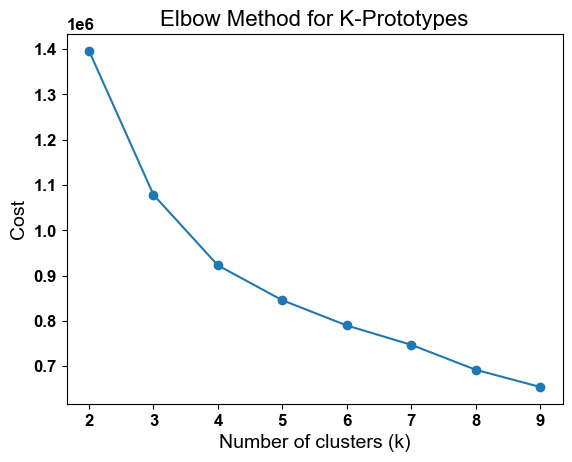

In [39]:
# 建立並訓練K-prototypes；自己分群不指定n
costs = []
k_range = range(2, 10)

for k in tqdm(k_range, desc="K-Prototypes clustering"):
    kproto = KPrototypes(n_clusters=k, init='Cao', random_state=42, verbose=0) # Cao演算法決定初始中心點；verbose = 0為不輸出過程細節
    kproto.fit_predict(data, categorical = cat_idx)
    costs.append(kproto.cost_)

# 畫手肘圖
plt.plot(k_range, costs, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Cost')
plt.title('Elbow Method for K-Prototypes')
plt.show()

In [43]:
costs

[1396014.55,
 1078339.92,
 922538.18,
 845587.77,
 789957.2,
 747296.7,
 692220.76,
 654227.47]

In [45]:
# 計算下降幅度找最適合分群的k值
costs = [
    1396014.55,  # k=2
    1078339.92,  # k=3
    922538.18,   # k=4
    845587.77,   # k=5
    789957.20,   # k=6
    747296.70,   # k=7
    692220.76,   # k=8
    654227.47    # k=9
]

k_range = range(2, 10)

improvements = [0]
for i in range(1, len(costs)):
    prev, curr = costs[i-1], costs[i]
    improvements.append((prev-curr)/prev * 100) # 百分比下降

df_improve = pd.DataFrame({
    'k': list(k_range),
    'cost': costs,
    'improvements_%': improvements
})

df_improve


,k,cost,improvements_%
0,2,1396014.55,0.000000
1,3,1078339.92,22.755825
2,4,922538.18,14.448296
3,5,845587.77,8.341163
4,6,789957.20,6.578923
5,7,747296.70,5.400356
6,8,692220.76,7.370023
7,9,654227.47,5.488609


- k-prototypes 模型正式建立與訓練

In [46]:
# 建立 k-prototypes模型(4群)
kproto = KPrototypes(n_clusters=4, init='Cao', random_state=42, verbose=1)

clusters = kproto.fit_predict(data, categorical = cat_idx)

df_normalized['cluster'] = clusters

# 每一群人數
print(df_normalized['cluster'].value_counts())

#
print(kproto.cluster_centroids_)

Initialization method and algorithm are deterministic. Setting n_init to 1.
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 3015, ncost: 1131882.2960752163
Run: 1, iteration: 2/100, moves: 1215, ncost: 1070118.8411843535
Run: 1, iteration: 3/100, moves: 761, ncost: 1043730.1908273132
Run: 1, iteration: 4/100, moves: 566, ncost: 1029214.8563333501
Run: 1, iteration: 5/100, moves: 454, ncost: 1017977.3631728796
Run: 1, iteration: 6/100, moves: 403, ncost: 1012213.876471942
Run: 1, iteration: 7/100, moves: 553, ncost: 1001984.9562555058
Run: 1, iteration: 8/100, moves: 1304, ncost: 970456.5389010472
Run: 1, iteration: 9/100, moves: 1072, ncost: 954760.1483610044
Run: 1, iteration: 10/100, moves: 432, ncost: 948275.4530477832
Run: 1, iteration: 11/100, moves: 334, ncost: 943340.7402029093
Run: 1, iteration: 12/100, moves: 287, ncost: 938476.5589182195
Run: 1, iteration: 13/100, moves: 282, ncost: 931886.9543601973
Run: 1, ite

In [48]:
# 每一群人數
df_normalized['cluster'].value_counts()

cluster
0    10101
2     3154
3      758
1       78
Name: count, dtype: int64

In [55]:
# 先看可解釋變異程度再決定視覺化分群方法
pca = PCA()
pca.fit(data)
explained = pca.explained_variance_ratio_

print('前10個主成分解釋比例：',explained[:10]) # 前10個主成分解釋比例
print('前2個主成分累積解釋率：',sum(explained[:2]))

前10個主成分解釋比例： [0.70102335 0.09532133 0.05111544 0.04195557 0.04059231 0.02013581
 0.01222646 0.0073209  0.00688914 0.00506799]
前2個主成分累積解釋率： 0.7963446762723471


##### PCA

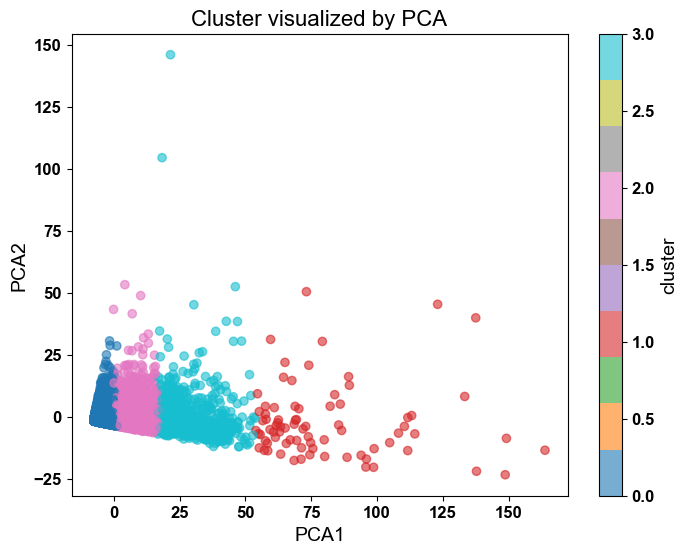

In [56]:
pca = PCA(n_components=2)
reduced = pca.fit_transform(data)

# 畫scatter
plt.figure(figsize=(8,6))
plt.scatter(reduced[:,0], reduced[:,1], # pca兩維
            c = df_normalized['cluster'],
            cmap='tab10', alpha=0.6)\
            
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.title('Cluster visualized by PCA')
plt.colorbar(label = 'cluster')
plt.show()

#### 5.3 每個群組的特徵統計量

In [58]:
cluster_full=allfeature.copy()
cluster_full['cluster'] = clusters
cluster_full

,UserID,UserSex,年平均消費金額,年平均消費次數,3C,X[麗文禮券,不計算業績,二手書,促銷代碼,其他,...,設計、文具,食品,現金支付比例,刷卡支付比例,一卡通支付比例,LinePay支付比例,紅利年平均折抵次數,禮卷年平均折抵次數,年平均兌換頻率,cluster
0,955825516,0,3002.000000,16.500000,1,0,0,0,4,0,...,72,0,1.000,0.0,0.0,0.00,4.714286,4.714286,0.0,1
1,903632160,1,373.666667,2.666667,1,0,1,0,4,0,...,6,0,0.625,0.0,0.0,0.25,2.666667,2.666667,0.0,0
2,983835662,1,944.500000,3.750000,0,0,2,0,3,0,...,15,1,1.000,0.0,0.0,0.00,3.000000,3.000000,0.0,2
3,979872208,0,1924.000000,3.333333,1,0,0,0,3,0,...,13,0,1.000,0.0,0.0,0.00,2.000000,2.000000,0.0,2
4,919061387,0,515.000000,2.500000,1,0,0,1,1,0,...,3,0,1.000,0.0,0.0,0.00,2.500000,2.500000,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14086,983020530,0,64.000000,1.000000,0,0,0,0,0,0,...,1,0,1.000,0.0,0.0,0.00,1.000000,1.000000,0.0,0
14087,958016116,1,349.000000,1.000000,1,0,0,0,0,0,...,0,0,0.000,1.0,0.0,0.00,1.000000,1.000000,0.0,0
14088,916420981,1,1288.000000,1.000000,0,0,0,0,0,0,...,0,0,1.000,1.0,0.0,0.00,1.000000,1.000000,0.0,0
14089,982020831,0,855.000000,1.000000,0,0,0,0,0,0,...,0,0,1.000,1.0,0.0,0.00,1.000000,1.000000,0.0,0


In [60]:
# 計算每個群組的特徵統計量
pd.set_option('display.max_columns', None)
cluster_summary = cluster_full.groupby('cluster').describe().reset_index()
cluster_summary

cluster  UserSex                                               年平均消費金額  \
             count      mean       std  min  25%  50%  75%  max    count   
0       0  10101.0  0.506584  0.499981  0.0  0.0  1.0  1.0  1.0  10101.0   
1       1     78.0  0.628205  0.486412  0.0  0.0  1.0  1.0  1.0     78.0   
2       2   3154.0  0.560558  0.496398  0.0  0.0  1.0  1.0  1.0   3154.0   
3       3    758.0  0.621372  0.485365  0.0  0.0  1.0  1.0  1.0    758.0   

                                                                   \
          mean          std         min          25%          50%   
0  1230.569003  3705.682095    0.000000   287.000000   681.000000   
1  3803.096154  2768.445936  736.333333  1654.666667  2791.250000   
2  1578.387445  3220.146792    0.000000   540.562500  1005.333333   
3  2335.695471  5633.177424  132.666667   861.166667  1443.000000   

                          年平均消費次數                                       \
           75%       max    count       mean       std   min       25%   
0  1349.000000  277685.0  10101.0   2.110377  1.271460  1.00  1.000000   
1  5149.291667   13370.5     78.0  12.616453  5.493689  3.25  8.541667   
2  1787.250000  101350.0   3154.0   4.404249  2.063711  1.00  3.000000   
3  2505.250000  126668.0    758.0   7.061785  3.172894  1.00  5.000000   

                                      3C                                     \
      50%        75%        max    count      mean       std  min  25%  50%   
0   2.000   3.000000  17.000000  10101.0  0.242055  0.719817  0.0  0.0  0.0   
1  11.625  15.583333  30.666667     78.0  3.564103  4.479650  0.0  1.0  2.0   
2   4.000   5.333333  19.000000   3154.0  0.818960  1.590252  0.0  0.0  0.0   
3   6.500   8.500000  28.000000    758.0  1.606860  2.675503  0.0  0.0  1.0   

               X[麗文禮券                                                 不計算業績  \
   75%   max    count      mean       std  min  25%  50%  75%  max    count   
0  0.0  14.0  10101.0  0.000693  0.038531  0.0  0.0  0.0  0.0  3.0  10101.0   
1  5.0  21.0     78.0  0.000000  0.000000  0.0  0.0  0.0  0.0  0.0     78.0   
2  1.0  21.0   3154.0  0.000317  0.017806  0.0  0.0  0.0  0.0  1.0   3154.0   
3  2.0  35.0    758.0  0.003958  0.081175  0.0  0.0  0.0  0.0  2.0    758.0   

                                                     二手書                      \
       mean       std  min  25%  50%  75%   max    count      mean       std   
0  0.635086  1.590471  0.0  0.0  0.0  1.0  66.0  10101.0  0.003366  0.070279   
1  4.935897  7.769972  0.0  1.0  2.0  7.0  61.0     78.0  0.051282  0.274332   
2  1.323716  2.780390  0.0  0.0  1.0  2.0  76.0   3154.0  0.005073  0.079482   
3  2.456464  4.503641  0.0  0.0  1.0  3.0  46.0    758.0  0.014512  0.248749   

                               促銷代碼                                       \
   min  25%  50%  75%  max    count       mean        std  min  25%  50%   
0  0.0  0.0  0.0  0.0  3.0  10101.0   1.132264   1.811823  0.0  0.0  1.0   
1  0.0  0.0  0.0  0.0  2.0     78.0  11.487179  12.285292  0.0  4.0  7.5   
2  0.0  0.0  0.0  0.0  2.0   3154.0   2.677552   3.323697  0.0  1.0  2.0   
3  0.0  0.0  0.0  0.0  6.0    758.0   5.126649   6.539166  0.0  2.0  4.0   

                     其他                                                \
     75%   max    count      mean       std  min  25%  50%  75%   max   
0   2.00  29.0  10101.0  0.058212  1.324027  0.0  0.0  0.0  0.0  66.0   
1  13.75  54.0     78.0  0.884615  5.943414  0.0  0.0  0.0  0.0  51.0   
2   4.00  46.0   3154.0  0.216550  2.504110  0.0  0.0  0.0  0.0  75.0   
3   7.00  98.0    758.0  0.506596  3.692877  0.0  0.0  0.0  0.0  45.0   

     可諾進出口                                                 學校紀念品            \
     count      mean       std  min  25%  50%  75%  max    count      mean   
0  10101.0  0.018612  0.158739  0.0  0.0  0.0  0.0  4.0  10101.0  0.093159   
1     78.0  0.076923  0.268194  0.0  0.0  0.0  0.0  1.0     78.0  0.423077   
2   3154.0  0.053266  0.253770  0.0  0.0  0.0 

此分群顯示四群在紅利年平均折抵次數、禮券年平均折抵次數、年平均兌換頻率有明顯差異，以下以 Cluster 0 到 Cluster 3 呈現：  

| Cluster | 人數 | 年平均消費金額 |年平均中位數| 紅利年平均折抵次數 | 禮券年平均折抵次數 | 年平均兌換頻率 |
|---------|------|--------------|-----------|-------------------|------------------|---------------|
| 0       | 10101| 1230.57      | 681       | 1.657783          | 1.657783         | 0.252813      |
| 1       | 78   | 3803.10      | 2791.25   | 5.049605          | 5.049605         | 1.615384      |
| 2       | 3154 | 1578.39      | 1005.33   | 2.709438          | 2.709438         | 0.490276      |
| 3       | 758  | 2335.70      | 1443      | 3.860831          | 3.860831         | 0.834432      |

Cluster 0 ：消費低 + 折抵少 -> 大眾沉默顧客 (人數最多，參與度不足但有潛力)  
Cluster 1 ：消費高 + 折抵多 -> 忠誠顧客 (人數最少，適合個人化的行銷)  
Cluster 2 ：消費中 + 折抵中 -> 穩定中層顧客 (皆屬中等，可透過優惠提升活躍度)  
Cluater 3 ：消費高 + 折抵少 -> 高消費低折抵顧客 (未充分被觸及折抵資訊)  


-  因為考慮到行銷的投入預算，所以只能選出其中兩群來做行銷
    - Cluster 0：雖然消費低，但人數龐大；只要少部分的人了解紅利的好處與兌換的相關資訊，就能提高使用率
    - Cluster 3：消費力強，點數基數大，但使用率低 -> 提升點數使用率，短期內對營收、參與度提升最明顯

##### 進一步瞭解行銷群的購買行為

In [105]:
# 只取mean的欄位
mean_df = cluster_summary.xs('mean', axis=1, level=1)
mean_df = mean_df.reset_index()

mean_df.head()


,index,UserSex,年平均消費金額,年平均消費次數,3C,X[麗文禮券,不計算業績,二手書,促銷代碼,其他,可諾進出口,學校紀念品,教科書,業外,生活百貨,社會書,穿搭配飾,簡體字書,美妝,藍海經銷,蘋果原廠產品,設計、文具,食品,現金支付比例,刷卡支付比例,一卡通支付比例,LinePay支付比例,紅利年平均折抵次數,禮卷年平均折抵次數,年平均兌換頻率
0,0,0.506584,1230.569003,2.110377,0.242055,0.000693,0.635086,0.003366,1.132264,0.058212,0.018612,0.093159,1.341253,0.076329,0.343035,0.584497,0.018414,0.003069,0.000693,0.046332,0.014454,2.224433,0.016236,0.756371,0.056391,0.108571,0.089673,1.657783,1.657783,0.252813
1,1,0.628205,3803.096154,12.616453,3.564103,0.000000,4.935897,0.051282,11.487179,0.884615,0.076923,0.423077,4.064103,0.948718,9.025641,6.987179,0.538462,0.051282,0.012821,0.243590,0.153846,84.974359,0.282051,0.835219,0.059871,0.015079,0.064525,5.049605,5.049605,1.615385
2,2,0.560558,1578.387445,4.404249,0.818960,0.000317,1.323716,0.005073,2.677552,0.216550,0.053266,0.207990,2.119531,0.208624,1.589093,1.334813,0.096068,0.008878,0.000634,0.079581,0.029486,12.991439,0.038681,0.806710,0.045275,0.038265,0.090589,2.709439,2.709439,0.490277
3,3,0.621372,2335.695471,7.061785,1.606860,0.003958,2.456464,0.014512,5.126649,0.506596,0.109499,0.418206,3.290237,0.423483,3.023747,3.098945,0.196570,0.035620,0.005277,0.163588,0.026385,32.957784,0.126649,0.818210,0.044644,0.025763,0.084447,3.860832,3.860832,0.834433


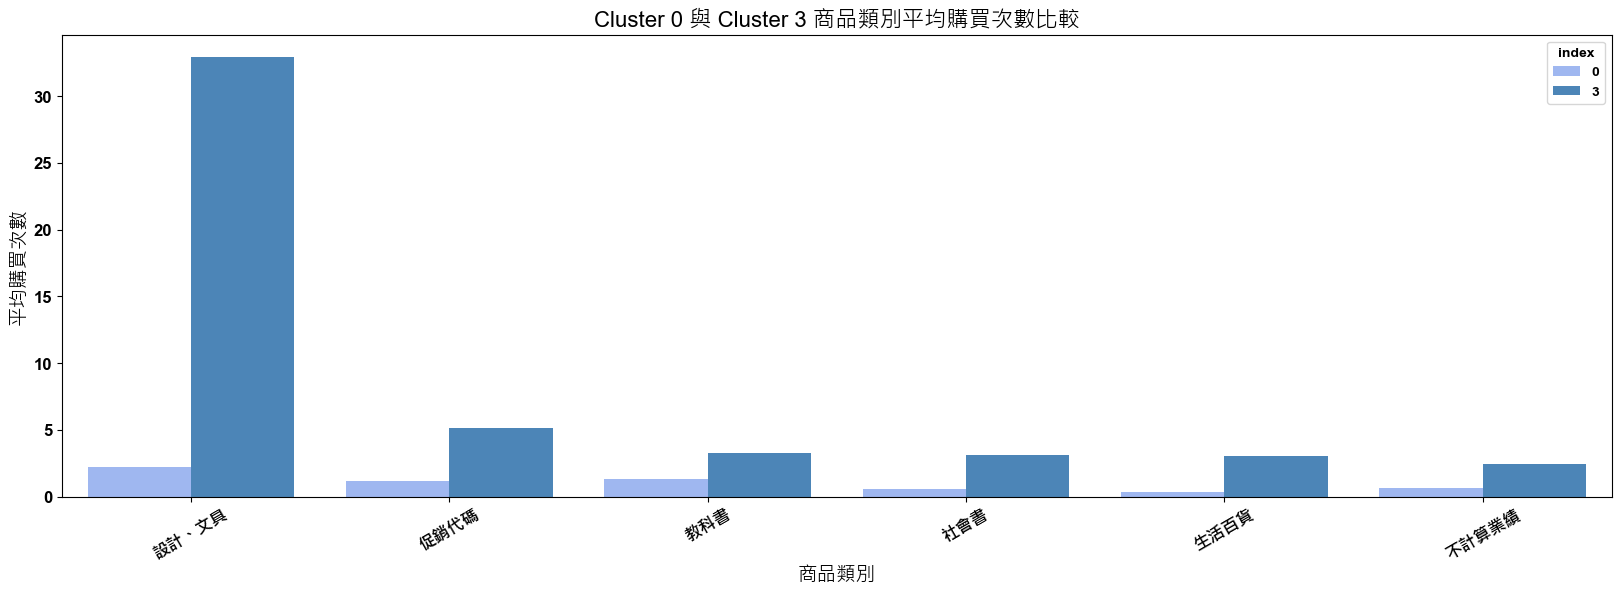

In [121]:

purchase_cols = ['3C', '設計、文具', '二手書', '促銷代碼','不計算業績','其他','可諾進出口','學校紀念品','教科書','業外','生活百貨','社會書','穿搭配飾','簡體字書','美妝','藍海經銷','蘋果原廠產品','食品']

cluster_purchases = mean_df[['index'] + purchase_cols]

cluster_purchases_melt = cluster_purchases.melt(
    id_vars='index',
    var_name='商品類別',
    value_name='平均購買次數'
)

# 篩選只要 Cluster 0 和 3
target_clusters = [0, 3]
cluster_purchases_target = cluster_purchases_melt[
    cluster_purchases_melt['index'].isin(target_clusters)
]

# 計算每個商品在兩群的總平均
product_means = (
    cluster_purchases_target.groupby("商品類別")["平均購買次數"]
    .sum()
)

# 只保留總平均 > 3 的商品
valid_products = product_means[product_means > 3].index
cluster_purchases_target = cluster_purchases_target[
    cluster_purchases_target["商品類別"].isin(valid_products)
]

# 商品依照兩群的總平均排序
order = product_means.loc[valid_products].sort_values(ascending=False).index

colors = ["#91b1fe", "#3a86c9"]

plt.figure(figsize=(20,6))
sns.barplot(
    data=cluster_purchases_target,
    x='商品類別',
    y='平均購買次數',
    hue='index',
    order=order,
    palette=colors
)
plt.title("Cluster 0 與 Cluster 3 商品類別平均購買次數比較")
plt.xticks(rotation=30)
plt.show()


- 支付方式比較

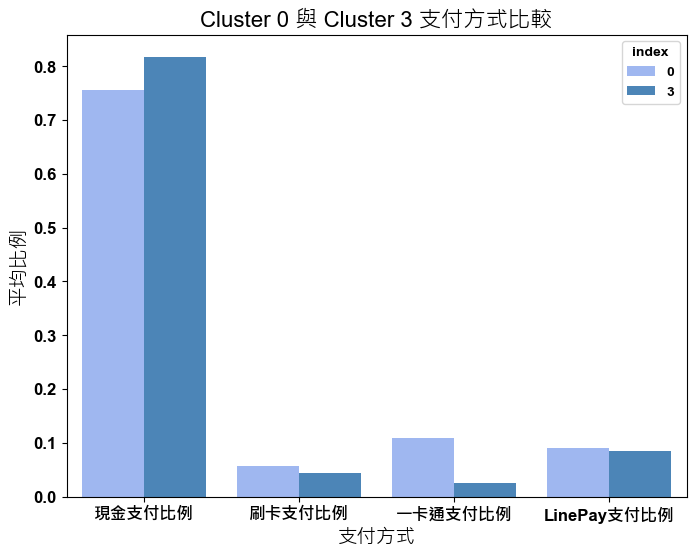

In [122]:
target_clusters = [0, 3]
pay_cols = ['現金支付比例', '刷卡支付比例', '一卡通支付比例', 'LinePay支付比例']

colors = ["#91b1fe", "#3a86c9"]

# 篩選目標群
pay_melt = mean_df[mean_df['index'].isin(target_clusters)][['index'] + pay_cols] \
    .melt(id_vars='index', value_vars=pay_cols, 
          var_name='支付方式', value_name='比例')

plt.figure(figsize=(8,6))
sns.barplot(data=pay_melt, x='支付方式', y='比例', hue='index',palette=colors)
plt.title("Cluster 0 與 Cluster 3 支付方式比較")
plt.ylabel("平均比例")
plt.show()


#### 6.4 依分群發想行銷方向
1. 前面提及，因為行銷預算的關係，所以通常只能從中選出幾群行銷。在這個專案中選出Cluster0與Cluster3行銷
    - Cluster 0：大眾沉默顧客
    - Cluater 3：高消費低折抵顧客

2. 行銷方向(針對客群的其他特徵思考)  
- 大眾沉默顧客


| 特徵 | 描述 |
|---------|---------|
| 消費金額 | 年平均消費金額最低|
| 消費頻率 | 年平均消費次數也偏低，但整體人數最多 |
| 常購買類別 | 主要消費在設計文具、有促銷代碼相關分類，教科書與生活百貨 |
| 支付方式 | 主要使用現金支付，其次是 一卡通 |
| 紅利與禮券使用率 | 紅利與禮券折抵參與度普遍低，顯示對點數活動敏感度不高 |

- 行銷策略
    - 設計入門型促銷方案：強調「小額即享優惠」，例如：設計文具、書籍單筆滿 NT$300 折抵 NT$20
    - 提升紅利使用動機：針對低消費次數客群，推廣「紅利點數＋Line Pay」綁定回饋，刺激使用意願
    - 鎖定大基數推廣：雖然個人消費力低，但人數龐大，適合進行「全體性優惠推播」



<hr>

- 高消費低折抵顧客


| 特徵 | 描述 |
|---------|---------|
| 消費金額 | 年平均消費金額高 |
| 消費頻率 | 消費頻率中等至偏高 |
| 常購買類別 | 設計文具、有促銷代碼相關商品、教科書等 |
| 支付方式 | 使用現金為多數、LINE Pay為其次 |
| 紅利與禮券使用率 | 即使消費力高，但紅利與禮券折抵使用率使用率並沒有想像中高，有進步潛力 |

- 行銷策略
    - 強化回饋誘因：針對高消費者設計「紅利加倍回饋」，例如消費滿 NT$1,000 紅利點數翻倍」
    - VIP 專屬方案：提供「高消費專屬折扣碼」，提升其對折抵的參與度
    - 品類推廣：利用其高消費習慣，引導消費到其他品類（如 3C／生活百貨），提高整體購買多樣性
